<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   article_id                  1003 non-null   int64         
 1   title                       1003 non-null   object        
 2   text                        1003 non-null   object        
 3   published_date              1003 non-null   datetime64[ns]
 4   unique_tokens_rate          1003 non-null   float64       
 5   num_hrefs                   1003 non-null   int64         
 6   num_imgs                    1003 non-null   int64         
 7   num_videos                  1003 non-null   int64         
 8   average_token_length        1003 non-null   float64       
 9   num_keywords                1003 non-null   int64         
 10  data_channel                1003 non-null   object        
 11  min_avg_key                 1003 non-null   float64     

,shares
count,1000.000000
mean,4243.046000
std,22641.282639
min,58.000000
25%,1000.000000
50%,1600.000000
75%,3100.000000
max,663600.000000


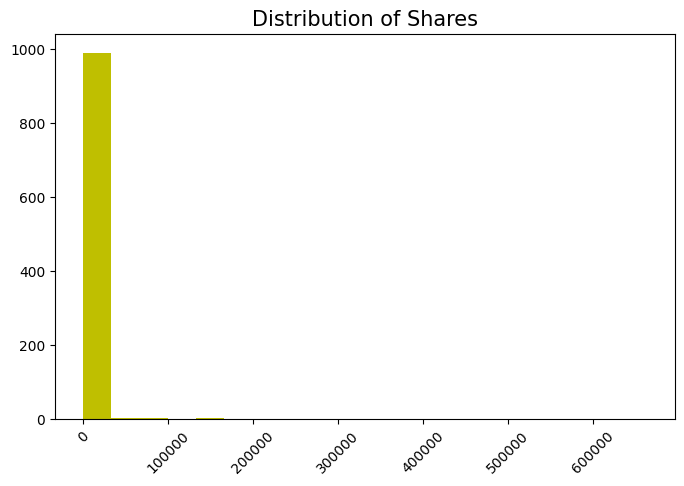

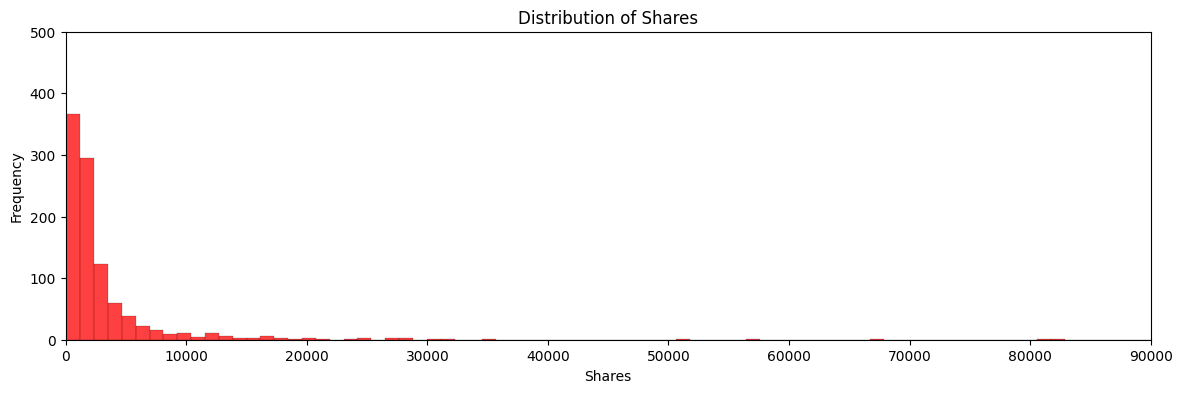

'No April Foolâ€™s joke: Thereâ€™s a comedy cable network in your pocket, and you\'ll be happy to see it.\n\nFurther blurring the lines between TVs and mobile devices, Comedy Central launched an all-new app Tuesday that will offer a generous helping of its flagship content for free -- and weâ€™re talking full episodes here, not just clips or extras -- on smartphones and tablets.\n\n[seealso slug="ipad-apps-free"]\n\nExisting separate apps for The Daily Show With Jon Stewart and The Colbert Report, which mostly offered snippets and second-screen goodies, have been scuttled effective immediately. And for good reason: The network\'s entire late-night lineup, which includes Chris Hardwickâ€™s @midnight, will be offered on the app for next-day viewing, as will the most recent season of South Park.\n\n"This is TV moving to the tablet, not the website. The idea is bigger than the app -- this is the network," Steve Grimes, SVP of multi-platform programming and strategy, told Mashable during a 

In [4]:
import numpy as np
import pandas as pd

import os
import math
import time
import re

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances



df_test = pd.read_excel("/content/news_share_data.xlsx")
df_test.head()

df_test.columns



df_test.info()

df_test.shape



df_test.isnull().sum()

df_test.duplicated().sum()



df_test = df_test[df_test['title'].apply(lambda x: len(x.split())>4)]
print("Total number of articles after removal of title with short title:", df_test.shape[0])

df_test.shape


df_test.describe()

print("Summary Statistics of Shares:")
display(df_test[['shares']].describe())

plt.figure(figsize=(8,5))
plt.hist(df_test['shares'],bins=20, color = 'y')
plt.title("Distribution of Shares",size=15)
plt.xticks(rotation=45)
plt.show()


array_shares = df_test['shares']

plt.figure(figsize=(14,4))
sns.histplot(array_shares, color = 'r', bins= 577, cbar= True)
plt.xlabel('Shares')
plt.ylabel('Frequency')
plt.title('Distribution of Shares')
plt.xlim(0, 90000)  # Set the y-axis limit
plt.ylim(0, 500)  # Set the y-axis limit
plt.show()



df_test['text'].loc[15]


In [7]:
import nltk

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

def preprocess_text(text):

    text = text.lower()


    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r"'\s+", " ", text)
    text = re.sub(r"\s+'", " ", text)

    text = re.sub(r'[^\w\s]', '', text)


    tokens = word_tokenize(text)


    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]


    cleaned_text = ' '.join(tokens)

    return cleaned_text


df_test['cleaned_text'] = df_test['text'].apply(preprocess_text)
df_test['cleaned_title'] = df_test['title'].apply(preprocess_text)

df_test['cleaned_text'] .loc[15]

df_test['cleaned_title'].loc[15]

weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_test['weekday'] = df_test['published_date'].apply(lambda x: pd.to_datetime(x).day_name())


weekend_names = ['Friday', 'Saturday']


df_test['is_weekend'] = df_test['weekday'].apply(lambda x: 1 if x in weekend_names else 0)


month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_test['month'] = df_test['published_date'].apply(lambda x: month_names[pd.to_datetime(x).month - 1])

df_test.sample(n=5)


df_test['data_channel'].value_counts()


color_scale = px.colors.sequential.Cividis

fig = go.Figure(
    [go.Bar(
        x=df_test["data_channel"].value_counts().index,
        y=df_test["shares"].value_counts().values,
        marker_color=color_scale
    )]
)

fig.update_layout(
    title={"text": 'Distribution of articles Data channel-wise', 'y': 0.9, 'x': 0.5,},
    xaxis_title="Data channel name",
    yaxis_title="Number of articles"
)

fig.update_layout(width=800, height=700)
fig.show()

In [9]:
df_test['cleaned_data_channel'] = df_test['data_channel'].replace('00000', 'Others')
df_test['cleaned_data_channel'].value_counts()


## 4.5 Handling Categorical Data <a name = 'HCD_4.5' ></a>


# Applying one-hot encoding to the 'data_channel' column
enc_cleaned_data_channel = df_test[['cleaned_data_channel']]
enc_cleaned_data_channel = pd.get_dummies(enc_cleaned_data_channel, prefix= 'Channel', drop_first= True)
enc_cleaned_data_channel = enc_cleaned_data_channel.astype(int)
enc_cleaned_data_channel.head()

#concatenating one-hot encoded data channel with main dataframe
df_test = pd.concat([df_test,enc_cleaned_data_channel], axis = 1)
df_test.sample(5)

df_test.columns


Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'cleaned_text', 'cleaned_title',
       'weekday', 'is_weekend', 'month', 'cleaned_data_channel',
       'Channel_Entertainment', 'Channel_Lifestyle', 'Channel_Others',
       'Channel_Social Media', 'Channel_Tech'],
      dtype='object')

In [10]:

df_test['article_id_count'] = df_test.groupby('article_id')['article_id'].transform('count')

duplicate_articles = df_test[df_test['article_id_count'] > 1]

duplicate_articles

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech,article_id_count
510,7028680,Dove's Beauty Patch Experiment Wants You to Em...,"On the heels of last year's ""Beauty Sketches"" ...",2014-04-09,0.418367,30,4,1,4.379342,9,...,Wednesday,0,April,Lifestyle,0,1,0,0,0,2
511,7028680,"Dropbox Unveils Project Harmony, Mailbox for A...",Dropbox on Wednesday unveiled a suite of fresh...,2014-04-09,0.316504,42,11,0,4.540550,7,...,Wednesday,0,April,Business,0,0,0,0,0,2


In [11]:
df_test = df_test.drop(511, axis=0)
df_test[510:513]

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech,article_id_count
510,7028680,Dove's Beauty Patch Experiment Wants You to Em...,"On the heels of last year's ""Beauty Sketches"" ...",2014-04-09,0.418367,30,4,1,4.379342,9,...,Wednesday,0,April,Lifestyle,0,1,0,0,0,2
512,7028664,Facebook's Not Messing Around: Messenger Will ...,When Facebook acquired standalone messaging ap...,2014-04-09,0.442667,38,30,1,4.902760,7,...,Wednesday,0,April,Others,0,0,1,0,0,1
513,7028589,Facebook Overhauls and Limits Those Despised R...,When Facebook rolled out its last desktop rede...,2014-04-09,0.608108,6,0,0,4.693694,6,...,Wednesday,0,April,Tech,0,0,0,0,1,1


In [12]:

df_test = df_test.drop(columns = ['article_id', 'title', 'text', 'published_date','data_channel', ], axis=1)
desired_columns = ['cleaned_title', 'cleaned_text', 'weekday', 'is_weekend', 'month', 'cleaned_data_channel','Channel_Entertainment', 'Channel_Lifestyle',
                   'Channel_Others', 'Channel_Social Media', 'Channel_Tech', 'unique_tokens_rate',
                   'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
                   'num_keywords', 'min_avg_key', 'max_avg_key', 'avg_avg_key',
                   'href_avg_shares', 'global_subjectivity', 'global_sentiment_polarity',
                   'global_rate_positive_words', 'global_rate_negative_words',
                   'title_subjectivity', 'title_sentiment_polarity', 'shares']


df_test = df_test[desired_columns].copy()

In [ ]:
cols_to_treat = ['unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key',
       'max_avg_key', 'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares']

print("\nDistribution (BEFORE outlier treatment):")
display(df_test[cols_to_treat].describe())


Distribution (after outlier treatment using IQR method):


,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.532183,10.158158,4.260260,0.547548,4.675496,7.207207,1132.205907,5499.373117,3256.800153,4976.071248,0.450364,0.106496,0.037962,0.017433,0.293408,0.056851,2366.762763
std,0.099346,7.654816,5.105337,0.807028,0.284113,1.859846,1181.656104,2231.951378,1047.739362,5258.348719,0.091591,0.087908,0.014989,0.009358,0.325482,0.170974,1812.447026
min,0.272165,0.000000,0.000000,0.000000,3.942951,2.000000,0.000000,3568.870000,1360.101000,0.000000,0.224646,-0.114407,0.001300,0.000000,0.000000,-0.225000,58.000000
25%,0.466835,4.000000,1.000000,0.000000,4.490862,6.000000,0.000000,3613.040000,2534.726000,1300.000000,0.395563,0.051911,0.028655,0.011224,0.000000,0.000000,1000.000000
50%,0.533149,8.000000,2.000000,0.000000,4.685668,7.000000,984.066700,4635.807000,3004.755000,2766.667000,0.455990,0.102511,0.037325,0.016340,0.200000,0.000000,1600.000000
75%,0.596615,14.000000,7.000000,1.000000,4.856136,9.000000,2116.714500,6561.910000,3809.005000,7341.000000,0.509508,0.162790,0.046892,0.022606,0.500000,0.150000,3100.000000
max,0.791285,29.000000,16.000000,2.500000,5.404047,10.000000,3613.040000,10985.215000,5720.423500,16402.500000,0.680424,0.329107,0.074246,0.039680,1.000000,0.375000,6250.000000


unique_tokens_rate            float64
num_hrefs                       int64
num_imgs                        int64
num_videos                    float64
average_token_length          float64
num_keywords                    int64
min_avg_key                   float64
max_avg_key                   float64
avg_avg_key                   float64
href_avg_shares               float64
global_subjectivity           float64
global_sentiment_polarity     float64
global_rate_positive_words    float64
global_rate_negative_words    float64
title_subjectivity            float64
title_sentiment_polarity      float64
shares                          int64
dtype: object


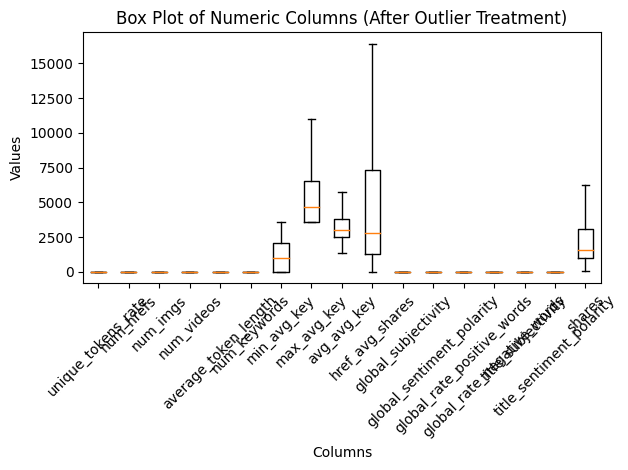

In [14]:
# Outlier treatment using IQR method
def treat_outliers_iqr(df_test, col):
    q1 = df_test[col].quantile(0.25)
    q3 = df_test[col].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df_test[col] = df_test[col].clip(lower=lower_bound, upper=upper_bound) #clipping every outliers
    return df_test

for col in cols_to_treat:
    df_test = treat_outliers_iqr(df_test, col)

print("\nDistribution (after outlier treatment using IQR method):")
display(df_test[cols_to_treat].describe())


print(df_test[cols_to_treat].dtypes)


import matplotlib.pyplot as plt

plt.boxplot(df_test[cols_to_treat])

plt.xticks(range(1, len(cols_to_treat) + 1), cols_to_treat, rotation=45)

plt.title('Box Plot of Numeric Columns (After Outlier Treatment)')
plt.xlabel('Columns')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

In [15]:

month_label_mapping = {'March': 3, 'April': 4}
week_label_mapping = {'Friday': 0,'Saturday': 1,'Sunday': 2,'Monday': 3, 'Tuesday': 4, 'Wednesday': 5,'Thursday' : 6}

df_test['month no'] = df_test['month'].map(month_label_mapping)
df_test['weekday no'] = df_test['weekday'].map(week_label_mapping)



#**2.2 Categorising all average shares**

df_test['avg shares daily'] = df_test.groupby('weekday')['shares'].transform('mean')
df_test['avg shares weekly'] = df_test.groupby('is_weekend')['shares'].transform('mean')
df_test['avg shares by channel'] = df_test.groupby('cleaned_data_channel')['shares'].transform('mean')


from nltk.tokenize import word_tokenize

def count_tokens(text):
    tokens = word_tokenize(text)
    return len(tokens)

df_test['title_tokens'] = df_test['cleaned_title'].apply(count_tokens)
df_test['text_tokens'] = df_test['cleaned_text'].apply(count_tokens)

df_test[['cleaned_title', 'cleaned_text', 'title_tokens', 'text_tokens']]




,cleaned_title,cleaned_text,title_tokens,text_tokens
0,time youtube competitor,reported last week yahoo getting online video ...,3,102
1,ultimate roundup 2014s biggest april fools day...,april fools marks day pranking goes corporate ...,8,54
2,selfie one garish jacket red sox white house,2013 world series champion boston red sox visi...,8,239
3,african telecom proposes diverse emoticons,less week apple pledged make emoticons raciall...,5,141
4,google launch improved android camera app repo...,android users may soon see series new features...,8,148
...,...,...,...,...
998,make caesar salad 8 super specific apps,lets cut chase apps lot bells whistles theres ...,7,47
999,taylor swift surprised fan bridal shower,taylor swift bridal showers made pastels baked...,6,133
1000,amazing spiderman 2 hosts first google hangout...,weve seen big movies throw big google hangouts...,10,84
1001,2 animators independently recreated pixar magic,pixar art directors robert kondo dice tsutsumi...,6,445


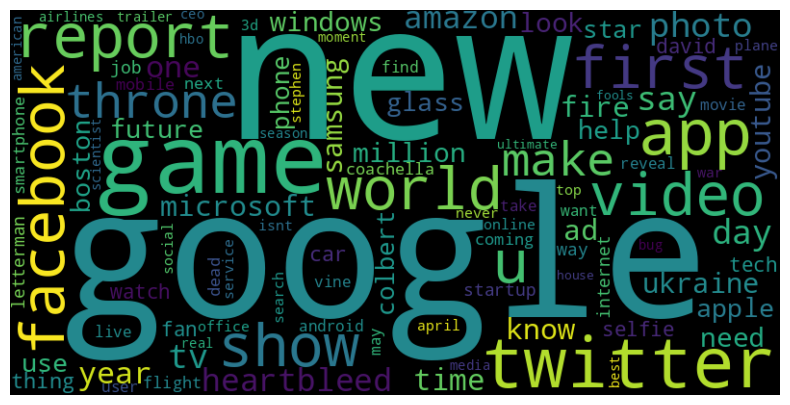

In [17]:
import re
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer

textw = " ".join(sent for sent in df_test['cleaned_title'])
wordcloud = WordCloud(width=800, height=400, background_color='black',
                      collocations=False, max_words=100).generate(textw)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


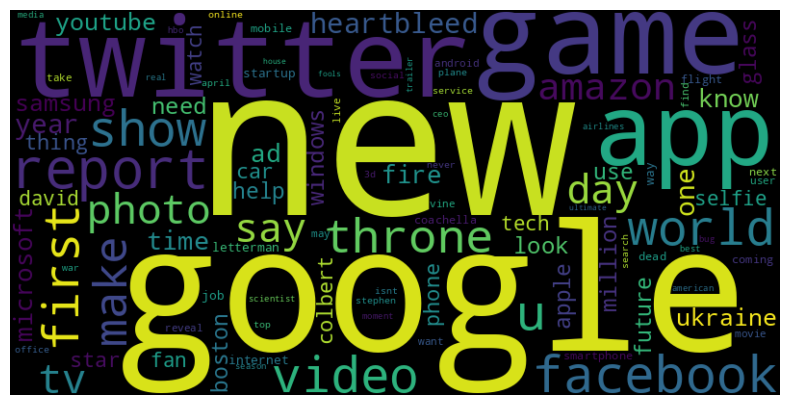

In [19]:
import re
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer

textw = " ".join(sent for sent in df_test['cleaned_title'])
wordcloud = WordCloud(width=800, height=400, background_color='black',
                      collocations=False, max_words=100).generate(textw)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [21]:
import nltk

nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [22]:


import nltk
from nltk import pos_tag

from collections import Counter


#1. Defining pos_tags function for counting

def count_and_classify_pos_tags(text):
    words = word_tokenize(text)  # Tokenizing the text
    pos_tags = pos_tag(words)    # Applying POS tagging

    # Counts
    noun_count = 0
    verb_count = 0
    adjective_count = 0

    # Iterating through POS tags and classifying them
    for word, tag in pos_tags:
        if tag.startswith('NN'):
            noun_count += 1
        elif tag.startswith('VB') or tag == 'RB' or tag == 'MD':  # Verbs and adverbs and modals
            verb_count += 1
        elif tag.startswith('JJ'):
            adjective_count += 1

    return {
        'noun_count': noun_count,
        'verb_count': verb_count,
        'adjective_count': adjective_count
    }


df_test['pos_counts_title'] = df_test['cleaned_title'].apply(count_and_classify_pos_tags)
df_test['pos_counts_text'] = df_test['cleaned_text'].apply(count_and_classify_pos_tags)


df_test[['noun_count_title', 'verb_count_title', 'adjective_count_title']] = df_test['pos_counts_title'].apply(pd.Series)
df_test[['noun_count_text', 'verb_count_text', 'adjective_count_text']] = df_test['pos_counts_text'].apply(pd.Series)

In [23]:
# Dropping the 'pos_counts_title and text' column as it woould not serve purpose in our analysis
df_test.drop('pos_counts_title', axis=1, inplace=True)
df_test.drop('pos_counts_text', axis=1, inplace=True)

df_test.head(3)

,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,avg shares weekly,avg shares by channel,title_tokens,text_tokens,noun_count_title,verb_count_title,adjective_count_title,noun_count_text,verb_count_text,adjective_count_text
0,time youtube competitor,reported last week yahoo getting online video ...,Monday,0,March,Business,0,0,0,0,...,2316.046429,2312.03681,3,102,2,0,0,49,28,20
1,ultimate roundup 2014s biggest april fools day...,april fools marks day pranking goes corporate ...,Tuesday,0,April,Tech,0,0,0,0,...,2316.046429,2676.02551,8,54,5,0,2,20,16,12
2,selfie one garish jacket red sox white house,2013 world series champion boston red sox visi...,Tuesday,0,April,Tech,0,0,0,0,...,2316.046429,2676.02551,8,239,3,1,3,103,56,53


In [24]:


from sklearn.feature_extraction.text import CountVectorizer

def Ngrams_extraction(descriptions):
    # Fill missing values with an empty string
    descriptions = descriptions.fillna('')

    vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=7)
    X = vectorizer.fit_transform(descriptions)
    ngram_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    return ngram_df

ngram_title_df = Ngrams_extraction(df_test['cleaned_title'])
ngram_txt_df = Ngrams_extraction(df_test['cleaned_text'])


ngram_title_df.head(5)


,amazon fire,april fools,fire tv,game thrones,google glass,need know,report says
0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1


In [25]:
df_test.isnull().sum()

cleaned_title                 0
cleaned_text                  0
weekday                       0
is_weekend                    0
month                         0
cleaned_data_channel          0
Channel_Entertainment         0
Channel_Lifestyle             0
Channel_Others                0
Channel_Social Media          0
Channel_Tech                  0
unique_tokens_rate            0
num_hrefs                     0
num_imgs                      0
num_videos                    0
average_token_length          0
num_keywords                  0
min_avg_key                   0
max_avg_key                   0
avg_avg_key                   0
href_avg_shares               0
global_subjectivity           0
global_sentiment_polarity     0
global_rate_positive_words    0
global_rate_negative_words    0
title_subjectivity            0
title_sentiment_polarity      0
shares                        0
month no                      0
weekday no                    0
avg shares daily              0
avg shar

In [27]:
df_test.shape

(999, 41)

In [30]:
df_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 1002
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cleaned_title               999 non-null    object 
 1   cleaned_text                999 non-null    object 
 2   weekday                     999 non-null    object 
 3   is_weekend                  999 non-null    int64  
 4   month                       999 non-null    object 
 5   cleaned_data_channel        999 non-null    object 
 6   Channel_Entertainment       999 non-null    int64  
 7   Channel_Lifestyle           999 non-null    int64  
 8   Channel_Others              999 non-null    int64  
 9   Channel_Social Media        999 non-null    int64  
 10  Channel_Tech                999 non-null    int64  
 11  unique_tokens_rate          999 non-null    float64
 12  num_hrefs                   999 non-null    int64  
 13  num_imgs                    999 no

In [32]:
df_test.isnull().sum()


cleaned_title                 0
cleaned_text                  0
weekday                       0
is_weekend                    0
month                         0
cleaned_data_channel          0
Channel_Entertainment         0
Channel_Lifestyle             0
Channel_Others                0
Channel_Social Media          0
Channel_Tech                  0
unique_tokens_rate            0
num_hrefs                     0
num_imgs                      0
num_videos                    0
average_token_length          0
num_keywords                  0
min_avg_key                   0
max_avg_key                   0
avg_avg_key                   0
href_avg_shares               0
global_subjectivity           0
global_sentiment_polarity     0
global_rate_positive_words    0
global_rate_negative_words    0
title_subjectivity            0
title_sentiment_polarity      0
shares                        0
month no                      0
weekday no                    0
avg shares daily              0
avg shar

In [34]:
df_test.shape


(999, 41)

In [35]:
#df_test_final.to_csv("data/news_test_data.csv",index=False)

In [37]:
df_test


,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,avg shares weekly,avg shares by channel,title_tokens,text_tokens,noun_count_title,verb_count_title,adjective_count_title,noun_count_text,verb_count_text,adjective_count_text
0,time youtube competitor,reported last week yahoo getting online video ...,Monday,0,March,Business,0,0,0,0,...,2316.046429,2312.036810,3,102,2,0,0,49,28,20
1,ultimate roundup 2014s biggest april fools day...,april fools marks day pranking goes corporate ...,Tuesday,0,April,Tech,0,0,0,0,...,2316.046429,2676.025510,8,54,5,0,2,20,16,12
2,selfie one garish jacket red sox white house,2013 world series champion boston red sox visi...,Tuesday,0,April,Tech,0,0,0,0,...,2316.046429,2676.025510,8,239,3,1,3,103,56,53
3,african telecom proposes diverse emoticons,less week apple pledged make emoticons raciall...,Tuesday,0,April,Tech,0,0,0,0,...,2316.046429,2676.025510,5,141,2,1,2,67,42,26
4,google launch improved android camera app repo...,android users may soon see series new features...,Tuesday,0,April,Others,0,0,1,0,...,2316.046429,2208.388571,8,148,5,2,1,62,49,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,make caesar salad 8 super specific apps,lets cut chase apps lot bells whistles theres ...,Thursday,0,April,Business,0,0,0,0,...,2316.046429,2312.036810,7,47,5,1,0,23,11,10
999,taylor swift surprised fan bridal shower,taylor swift bridal showers made pastels baked...,Thursday,0,April,Tech,0,0,0,0,...,2316.046429,2676.025510,6,133,5,1,0,66,32,21
1000,amazing spiderman 2 hosts first google hangout...,weve seen big movies throw big google hangouts...,Thursday,0,April,Entertainment,1,0,0,0,...,2316.046429,2139.983784,10,84,6,3,0,43,20,11
1001,2 animators independently recreated pixar magic,pixar art directors robert kondo dice tsutsumi...,Thursday,0,April,Business,0,0,0,0,...,2316.046429,2312.036810,6,445,2,2,1,212,126,80


In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 1002
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cleaned_title               999 non-null    object 
 1   cleaned_text                999 non-null    object 
 2   weekday                     999 non-null    object 
 3   is_weekend                  999 non-null    int64  
 4   month                       999 non-null    object 
 5   cleaned_data_channel        999 non-null    object 
 6   Channel_Entertainment       999 non-null    int64  
 7   Channel_Lifestyle           999 non-null    int64  
 8   Channel_Others              999 non-null    int64  
 9   Channel_Social Media        999 non-null    int64  
 10  Channel_Tech                999 non-null    int64  
 11  unique_tokens_rate          999 non-null    float64
 12  num_hrefs                   999 non-null    int64  
 13  num_imgs                    999 no

In [42]:
selelel = ['max_avg_key',
 'href_avg_shares',
 'avg shares daily',
 'unique_tokens_rate',
 'global_rate_positive_words',
 'min_avg_key',
 'avg_avg_key',
 'num_keywords',
 'global_sentiment_polarity',
 'verb_count_title',
 'average_token_length',
 'global_subjectivity',
 'title_readability',
 'global_rate_negative_words',
 'num_videos',
 'noun_count_title',
 'num_hrefs',
 'num_imgs',
 'shares']
print(df_test.columns)


Index(['cleaned_title', 'cleaned_text', 'weekday', 'is_weekend', 'month',
       'cleaned_data_channel', 'Channel_Entertainment', 'Channel_Lifestyle',
       'Channel_Others', 'Channel_Social Media', 'Channel_Tech',
       'unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'month no', 'weekday no',
       'avg shares daily', 'avg shares weekly', 'avg shares by channel',
       'title_tokens', 'text_tokens', 'noun_count_title', 'verb_count_title',
       'adjective_count_title', 'noun_count_text', 'verb_count_text',
       'adjective_count_text'],
      dtype='object')


<Axes: xlabel='shares', ylabel='Density'>

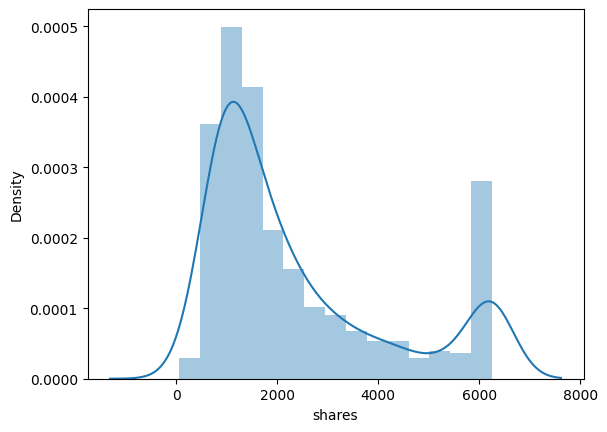

In [44]:
sns.distplot(df_test['shares'])
